# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [4]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = ["".join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train] # use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp] # use count_cpgs here to generate labels with temp generated in step2

    return X_dna_seqs_train, y_dna_seqs

train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [5]:
# some config
LSTM_HIDDEN = 128
LSTM_LAYER = 1
batch_size = 32
learning_rate = 0.0001
epoch_num = 30

In [6]:
# create data loader

# train_data_loader = ???
# test_Data_loader = ???


# Convert the training data to PyTorch tensors
train_x_tensor = torch.tensor(train_x)
train_y_tensor = torch.tensor(train_y).float().unsqueeze(1)  # Ensure train_y is a column vector

# Convert the test data to PyTorch tensors
test_x_tensor = torch.tensor(test_x)
test_y_tensor = torch.tensor(test_y).float().unsqueeze(1)  # Ensure test_y is a column vector

# Create a TensorDataset
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

# Create a DataLoader for the training data
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the test data
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:

# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self, input_size=5, hidden_size=128, num_layers=1, output_size=1):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # TODO complete forward function
        # Initialize hidden and cell states for each batch
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # Forward propagate LSTM

        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.classifier(out[:, -1, :])
        return out

In [8]:
# init model / loss function / optimizer etc.
model = CpGPredictor(input_size=5, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYER, output_size=1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
epoch_num = 100
# training (you can modify the code below)
t_loss = .0
model.train()
model.zero_grad()
for epoch in range(epoch_num):
    t_loss = 0.0
    t_correct = 0
    t_total = 0
    for x_batch, y_batch in train_data_loader:
        #TODO complete training loop
        # Forward pass
        x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
        outputs = model(x_one_hot)
        loss = loss_fn(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        t_total += y_batch.size(0)
        t_correct += (predicted == y_batch).sum().item()



    # Calculate average loss and accuracy for this epoch
    avg_loss = t_loss / len(train_data_loader)
    avg_acc = t_correct / t_total
    print(f'Training Accuracy : Epoch [{epoch+1}/{epoch_num}], Average Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f},train Loss: {loss.item()}')

    # Reset the total loss and accuracy for the next epoch
    t_loss = 0.0
    t_correct = 0
    t_total = 0

    # Print loss for each epoch
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    vt_correct = 0
    vt_total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_data_loader:
            x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
            outputs = model(x_one_hot)
            # outputs = model(x_batch)
            test_loss = loss_fn(outputs, y_batch)
            val_loss += test_loss.item()
            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            vt_total += y_batch.size(0)
            vt_correct += (predicted == y_batch).sum().item()
    # Calculate average loss and accuracy for this epoch
    avg_loss = val_loss / len(train_data_loader)
    avg_acc = vt_correct / vt_total
    print(f'Validation Accuracy : Epoch [{epoch+1}/{epoch_num}], Average Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}, Test Loss: {test_loss.item()}')


Training Accuracy : Epoch [1/100], Average Loss: 28.5745, Accuracy: 0.1250,train Loss: 22.037429809570312
Validation Accuracy : Epoch [1/100], Average Loss: 6.6048, Accuracy: 0.1250, Test Loss: 21.414852142333984
Training Accuracy : Epoch [2/100], Average Loss: 12.8245, Accuracy: 0.1250,train Loss: 4.404626846313477
Validation Accuracy : Epoch [2/100], Average Loss: 1.0945, Accuracy: 0.1250, Test Loss: 3.941118001937866
Training Accuracy : Epoch [3/100], Average Loss: 4.2166, Accuracy: 0.1250,train Loss: 3.2658848762512207
Validation Accuracy : Epoch [3/100], Average Loss: 1.0417, Accuracy: 0.1250, Test Loss: 4.356156826019287
Training Accuracy : Epoch [4/100], Average Loss: 4.1977, Accuracy: 0.1250,train Loss: 5.636416435241699
Validation Accuracy : Epoch [4/100], Average Loss: 1.0408, Accuracy: 0.1250, Test Loss: 4.333950042724609
Training Accuracy : Epoch [5/100], Average Loss: 4.1939, Accuracy: 0.1250,train Loss: 5.529223918914795
Validation Accuracy : Epoch [5/100], Average Loss: 

In [10]:
# eval (you can modify the code below)
model.eval()

res_gs = []
res_pred = []

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

with torch.no_grad():
  for batch in test_data_loader:
    # TODO complete inference loop
    x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
    x_one_hot = x_one_hot.to(device)
    y_batch = y_batch.to(device)
    outputs = model(x_one_hot)
    res_gs.extend(y_batch.tolist())
    res_pred.extend(outputs.squeeze().tolist())
    # outputs = model(x_batch)
  test_loss = loss_fn(outputs, y_batch)
  print("test_loss : ",test_loss)

# Convert the lists to numpy arrays for easier analysis
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

test_loss :  tensor(2.4914)


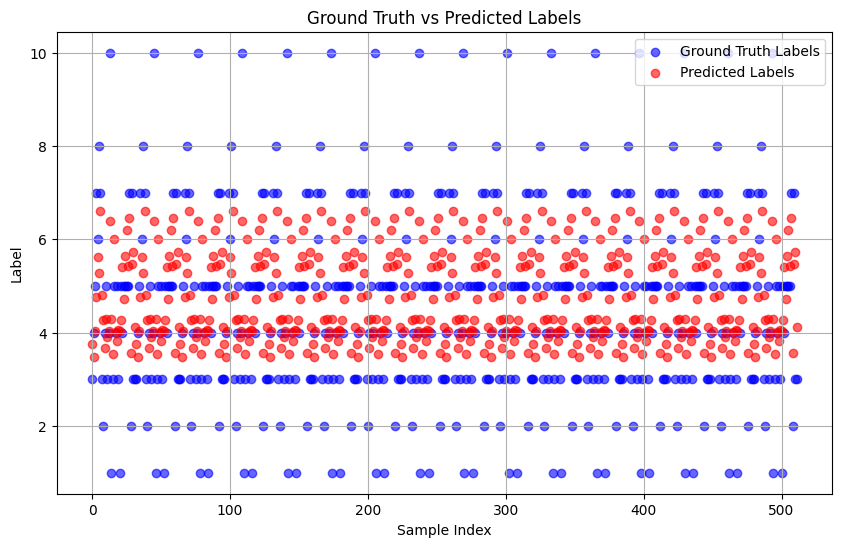

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are numpy arrays as mentioned
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Scatter plot for ground truth and predicted labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(res_gs)), res_gs, label='Ground Truth Labels', alpha=0.6, color='b')
plt.scatter(range(len(res_pred)), res_pred, label='Predicted Labels', alpha=0.6, color='r')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Ground Truth vs Predicted Labels')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(res_gs, res_pred)
mse = mean_squared_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Mean Absolute Error (MAE): 1.2492
Mean Squared Error (MSE): 2.4914
R-squared (R2) Score: 0.3673


In [13]:
# Save the model
model_path = '/content/drive/MyDrive/CpG/CP_Pred_model.pth'
torch.save(model.state_dict(), model_path)

In [14]:
#Prediction
import torch
import torch.nn.functional as F

# Define the mapping from nucleotides to integers
nucleotide_to_index = {'N': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}

# Function to convert a string of nucleotides to a tensor
def string_to_tensor(s, mapping):
    # Convert the string to a list of integers
    indices = [mapping[c] for c in s]
    # Convert the list to a tensor
    tensor = torch.tensor(indices)
    # One-hot encode the tensor
    one_hot = F.one_hot(tensor, num_classes=len(mapping))
    # Add a batch dimension
    one_hot = one_hot.unsqueeze(0).float()
    return one_hot

# Test string
test_string = "NAACGTANCGCGC"

# Convert the test string to a tensor
test_tensor = string_to_tensor(test_string, nucleotide_to_index)

# Load the model (assuming it's the same as before)
model = CpGPredictor()
state_dict = torch.load("/content/drive/MyDrive/CpG/CP_Pred_model.pth")

# Remove the unexpected keys from the state dictionary
unexpected_keys = ['lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1']
for key in unexpected_keys:
    if key in state_dict:
        print("key--------",key)
        del state_dict[key]

model.load_state_dict(state_dict, strict=False)
model.eval()

# Pass the tensor through the model
with torch.no_grad():
    prediction = model(test_tensor)

# Print the prediction
print(prediction)

tensor([[4.3726]])


# Part 2: what if the DNA sequences are not the same length

In [15]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [16]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [17]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp = ["".join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train]
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]

    # Convert the DNA sequences to integer sequences
    X_int_seqs_train = [list(dnaseq_to_intseq(seq)) for seq in temp]

    # Pad the sequences to the same length
    X_padded = pad_sequence([torch.tensor(seq) for seq in X_int_seqs_train], batch_first=True)

    return X_padded, torch.tensor(y_dna_seqs, dtype=torch.float32)


min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [18]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)


# this will be a collate_fn for dataloader to pad sequence
class PadSequence:
    #TODO
    def __call__(self, batch):
        # Separate sequences and labels from the batch
        sequences, labels = zip(*batch)

        # Convert sequences to tensors
        sequences = [torch.tensor(seq) for seq in sequences]

        # Pad the sequences
        padded_sequences = pad_sequence(sequences, batch_first=True)

        # Convert labels to a tensor
        labels = torch.stack(labels)

        return padded_sequences, labels

In [19]:
train_dataset = MyDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=PadSequence())

# You can do the same for the test dataset
test_dataset = MyDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, collate_fn=PadSequence())

In [20]:
# TODO complete the rest
class CpGPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, num_layers=1, output_size=1):
        super(CpGPredictor, self).__init__()
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Define the classifier layer
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states for each batch
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.classifier(out[:, -1, :])
        return out

In [21]:
model = CpGPredictor(input_size=5, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYER, output_size=1)
model


CpGPredictor(
  (lstm): LSTM(5, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)

In [22]:
# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Get the number of parameters
num_params = count_parameters(model)
print(f'The model has {num_params} trainable parameters')

The model has 69249 trainable parameters


In [23]:
loss_fn = nn.MSELoss()  # Use Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    t_loss = 0.0
    t_correct = 0
    t_total = 0
    for x_batch, y_batch in train_data_loader:
        # Forward pass
        # print(x_batch.shape)
        x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
        outputs = model(x_one_hot)
        loss = loss_fn(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        t_total += y_batch.size(0)
        t_correct += (predicted == y_batch).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_loss = t_loss / len(train_data_loader)
    avg_acc = t_correct / t_total
    print(f'Training Accuracy : Epoch [{epoch+1}/{epoch_num}], Average Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f},train Loss: {loss.item()}')

    t_loss = 0.0
    t_correct = 0
    t_total = 0

    # Print loss for each epoch
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    vt_correct = 0
    vt_total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_data_loader:
            x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
            outputs = model(x_one_hot)
            # outputs = model(x_batch)
            test_loss = loss_fn(outputs, y_batch)
            val_loss += test_loss.item()
            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            vt_total += y_batch.size(0)
            vt_correct += (predicted == y_batch).sum().item()
    # Calculate average loss and accuracy for this epoch
    avg_loss = val_loss / len(train_data_loader)
    avg_acc = vt_correct / vt_total
    print(f'Validation Accuracy : Epoch [{epoch+1}/{epoch_num}], Average Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}, Test Loss: {test_loss.item()}')
    # print(f'Epoch [{epoch+1}/{epoch_num}],Test Loss: {test_loss.item()}')


Training Accuracy : Epoch [1/100], Average Loss: 29.3084, Accuracy: 0.1250,train Loss: 32.341068267822266
Validation Accuracy : Epoch [1/100], Average Loss: 6.8849, Accuracy: 0.1250, Test Loss: 22.421491622924805
Training Accuracy : Epoch [2/100], Average Loss: 15.8598, Accuracy: 0.1250,train Loss: 7.679396629333496
Validation Accuracy : Epoch [2/100], Average Loss: 1.2614, Accuracy: 0.1250, Test Loss: 4.100080490112305
Training Accuracy : Epoch [3/100], Average Loss: 4.3962, Accuracy: 0.1250,train Loss: 4.593766689300537
Validation Accuracy : Epoch [3/100], Average Loss: 1.0393, Accuracy: 0.1250, Test Loss: 4.198634147644043
Training Accuracy : Epoch [4/100], Average Loss: 4.1977, Accuracy: 0.1250,train Loss: 3.4677677154541016
Validation Accuracy : Epoch [4/100], Average Loss: 1.0393, Accuracy: 0.1250, Test Loss: 4.24442720413208
Training Accuracy : Epoch [5/100], Average Loss: 4.1949, Accuracy: 0.1250,train Loss: 3.1370506286621094
Validation Accuracy : Epoch [5/100], Average Loss: 

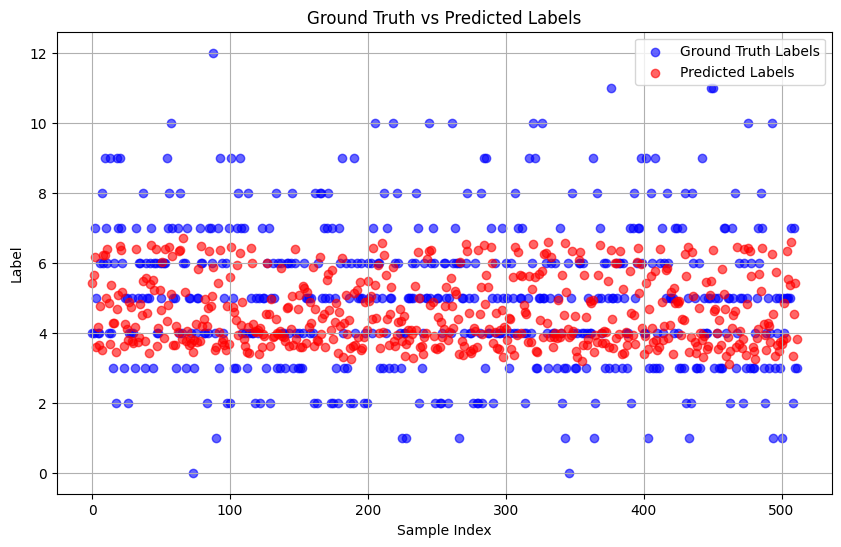

In [25]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
res_gs = []
res_pred = []

with torch.no_grad():  # Deactivate autograd for evaluation to save memory and speed up computations
    for x_batch, y_batch in test_data_loader:
        x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
        x_one_hot = x_one_hot.to(device)
        y_batch = y_batch.to(device)
        outputs = model(x_one_hot)
        res_gs.extend(y_batch.tolist())
        res_pred.extend(outputs.squeeze().tolist())
        # outputs = model(x_batch)
    test_loss = loss_fn(outputs, y_batch)
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Print the results or perform any other evaluation metrics you want

import numpy as np
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are numpy arrays as mentioned
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Scatter plot for ground truth and predicted labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(res_gs)), res_gs, label='Ground Truth Labels', alpha=0.6, color='b')
plt.scatter(range(len(res_pred)), res_pred, label='Predicted Labels', alpha=0.6, color='r')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Ground Truth vs Predicted Labels')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(res_gs, res_pred)
mse = mean_squared_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Mean Absolute Error (MAE): 1.4717
Mean Squared Error (MSE): 3.4493
R-squared (R2) Score: 0.1702


In [27]:
# Save the model
model_path = '/content/drive/MyDrive/CpG/CPG_Pred_model_padded.pth'
torch.save(model.state_dict(), model_path)

In [28]:
import torch
import torch.nn.functional as F

# Define the mapping from nucleotides to integers
nucleotide_to_index = {'N': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}

# Function to convert a string of nucleotides to a tensor
def string_to_tensor(s, mapping):
    # Convert the string to a list of integers
    indices = [mapping[c] for c in s]
    # Convert the list to a tensor
    tensor = torch.tensor(indices)
    # One-hot encode the tensor
    one_hot = F.one_hot(tensor, num_classes=len(mapping))
    # Add a batch dimension
    one_hot = one_hot.unsqueeze(0).float()
    return one_hot

# Test string
test_string = "NAACGTANCGCGGCGGGCCCCC"

# Convert the test string to a tensor
test_tensor = string_to_tensor(test_string, nucleotide_to_index)

# Load the model (assuming it's the same as before)
model = CpGPredictor()
state_dict = torch.load("/content/drive/MyDrive/CpG/CPG_Pred_model_padded.pth")

# Remove the unexpected keys from the state dictionary
unexpected_keys = ['lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1']
for key in unexpected_keys:
    if key in state_dict:
        print("key--------",key)
        del state_dict[key]

model.load_state_dict(state_dict, strict=False)
model.eval()

# Pass the tensor through the model
with torch.no_grad():
    prediction = model(test_tensor)

# Print the prediction
print(prediction)

tensor([[6.3371]])
